# 1. About the Problem (i.e Business Problem)
Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

## 1.1. Source:
[https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462](https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462)

## 1.2. Problem statement :

Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

## 1.3. Real-world/Business objectives and constraints
* No latency requirement.
* Interpretability is important.
* Errors can be costly.
* Probability of a data-point belonging to each class is needed.

# 2. Problem Formulation

### 2.1. Data Overview
#### Two data files-
1. training_variants (ID , Gene, Variations, Class)- It conatins the information about the genetic mutations.
2. training_text (ID, Text)- It contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations. 

### 2.2. Mapping the real world problem into ML problem
#### 2.2.1. Type of ML problem
```
    There are nine different classes a genetic mutation can be classified into => Multi class classification problem
```

#### 2.2.2. Performance Metric
Source: [https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview/evaluation](https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview/evaluation)
+ Multi class log-loss
+ Confusion Matrix

#### 2.2.3. ML Objectives and Constraints
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

# 3. Exploratory Data Analysis

## 3.1. Reading Data

### 3.1.1. Reading Text Data

In [61]:
import pandas as pd
# Since the separators for each ID and Text is "||", so need to mention separators
data_text = pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

#### Example data text point

In [62]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


##### Dimension of data

In [63]:
print('Number of data points : ', data_text.shape[0])  # Returns no. of rows
print('Number of features : ', data_text.shape[1])  # Returns no. of columns
print('Features : ', data_text.columns.values)  # Returns the column attributes

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


### 3.1.2. Reading Gene and Variation Data

### Example data point

In [64]:
data = pd.read_csv('training/training_variants')
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


##### Dimension of data

In [65]:
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


##### Various classes available are

In [66]:
data.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

**training/training_variants** is a comma separated file containing the description of the genetic mutations used for training.
Fields are-
* **ID** : the id of the row used to link the mutation to the clinical evidence
* **Gene** : the gene where this genetic mutation is located
* **Variation** : the aminoacid change for this mutations
* **Class** : 1-9 the class this genetic mutation has been classified on

### 3.1.3. Preprocessing of text

In [67]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    """ takes the text of each row, its column name and the index of the row
        do the required text processing and replaces the text with new text 
        in the particular column and row index """
    if type(total_text) is not int:
        string = ''
        # replace special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+', ' ', total_text)
        # converting all chars into lowercase
        total_text = total_text.lower()
        
        for word in total_text.split():
            # If word is not a stop word then retain the word from data
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string

##### Text Preprocessing stage

In [68]:
import time
start_time = time.time()

for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id ", index)

print("Time taken for processing the entire text is ", time.time()-start_time, "seconds")

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


There is no text description for id  1109
There is no text description for id  1277
There is no text description for id  1407
There is no text description for id  1639
There is no text description for id  2755
Time taken for processing the entire text is  222.77968049049377 seconds


### Merging both Dataframes

In [69]:
result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [70]:
result[result.isnull().any(axis=1)]  # Usually axis=0 is said to be "column-wise" (and axis=1 "row-wise")

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [71]:
# Replacing the Null texts with Gene and Variation values
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [72]:
result[result['ID']==1407]

,ID,Gene,Variation,Class,TEXT
1407,1407,FGFR3,K508M,6,FGFR3 K508M


### 3.1.4. Test, Train and Cross Validation Split

#### 3.1.4.1. Splitting data into train, test and cross validation (64:20:16

In [73]:
from sklearn.model_selection import train_test_split

y_true = result['Class'].values  # Taking Class values into separate dataframe for splitting
result.Gene = result.Gene.str.replace('\s+', '_')  # Replacing multiple spaces with underscores
result.Variation = result.Variation.str.replace('\s+', '_')

# Splitting into test and train by maintaining by maintaining same distribution of output variable 'y_true' [stratify=y_true]
X_train, test_df, Y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# Splitting into train and cross validation by maintaining same distribution of output variable 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2)

Data is splitted into train, test and CV by maintaining the ratio of class distribution in the original dataset

In [74]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


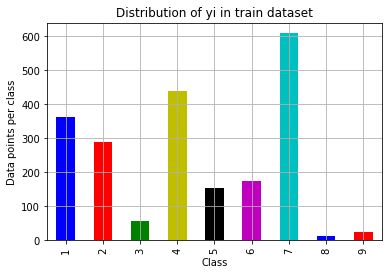

Number of datapoints in class 7 609 : 28.672 %
Number of datapoints in class 4 439 : 20.669 %
Number of datapoints in class 1 363 : 17.09 %
Number of datapoints in class 2 289 : 13.606 %
Number of datapoints in class 6 176 : 8.286 %
Number of datapoints in class 5 155 : 7.298 %
Number of datapoints in class 3 57 : 2.684 %
Number of datapoints in class 9 24 : 1.13 %
Number of datapoints in class 8 12 : 0.565 %


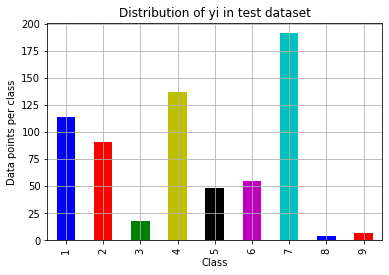

Number of datapoints in class 7 191 : 28.722 %
Number of datapoints in class 4 137 : 20.602 %
Number of datapoints in class 1 114 : 17.143 %
Number of datapoints in class 2 91 : 13.684 %
Number of datapoints in class 6 55 : 8.271 %
Number of datapoints in class 5 48 : 7.218 %
Number of datapoints in class 3 18 : 2.707 %
Number of datapoints in class 9 7 : 1.053 %
Number of datapoints in class 8 4 : 0.602 %


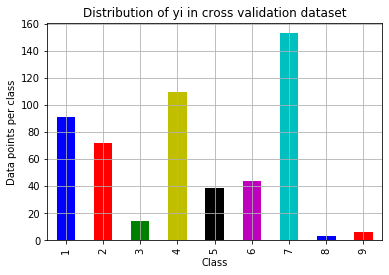

Number of datapoints in class 7 153 : 28.759 %
Number of datapoints in class 4 110 : 20.677 %
Number of datapoints in class 1 91 : 17.105 %
Number of datapoints in class 2 72 : 13.534 %
Number of datapoints in class 6 44 : 8.271 %
Number of datapoints in class 5 39 : 7.331 %
Number of datapoints in class 3 14 : 2.632 %
Number of datapoints in class 9 6 : 1.128 %
Number of datapoints in class 8 3 : 0.564 %


In [75]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle, islice  # To get colored bar graphs

# sort_index() returns a dictionary, with keys as the class labels and no. of data points
# in that class as values

train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'm', 'c']), None, len(train_class_distribution)))  # Gets list of colors

train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution of yi in train dataset')
plt.grid()
plt.show()

# (-train_class_distribution.values) gives the sorting in descending order
sorted_yi = np.argsort(-train_class_distribution.values)  # We get the indices of sorted values in decreasing order

for i in sorted_yi:
    print('Number of datapoints in class', i+1, train_class_distribution.values[i], ':', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%')

print('='*80)  #####################################################################################

my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'm', 'c']), None, len(test_class_distribution)))  # Gets list of colors

test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution of yi in test dataset')
plt.grid()
plt.show()

# (-test_class_distribution.values) gives the sorting in descending order
sorted_yi = np.argsort(-test_class_distribution.values)  # We get the indices of sorted values in decreasing order

for i in sorted_yi:
    print('Number of datapoints in class', i+1, test_class_distribution.values[i], ':', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%')

print('='*80)  #######################################################################################


my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'm', 'c']), None, len(cv_class_distribution)))  # Gets list of colors

cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution of yi in cross validation dataset')
plt.grid()
plt.show()

# (-train_class_distribution.values) gives the sorting in descending order
sorted_yi = np.argsort(-cv_class_distribution.values)  # We get the indices of sorted values in decreasing order

for i in sorted_yi:
    print('Number of datapoints in class', i+1, cv_class_distribution.values[i], ':', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%')

### Takeaways-
1. Imbalanced data
2. (7, 4, 1, 2) are dominating classes
3. Train, Test, CV have similar distribution of yi

## 3.2. Prediction using a random model
##### In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. 

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
        # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)  # Recall Matrix
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))  # Precision Matrix
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing C (Confusion Matrix) in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20, 7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B (Precision Matrix) in heatmap format
    print("-"*20, "Precision matrix", "-"*20)
    plt.figure(figsize=(20, 7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing A (Recall Matrix) in heatmap format
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(20, 7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on CV data using random model 2.401703235625778
Log loss on Test data using random model 2.44865456370503
-------------------- Confusion matrix --------------------


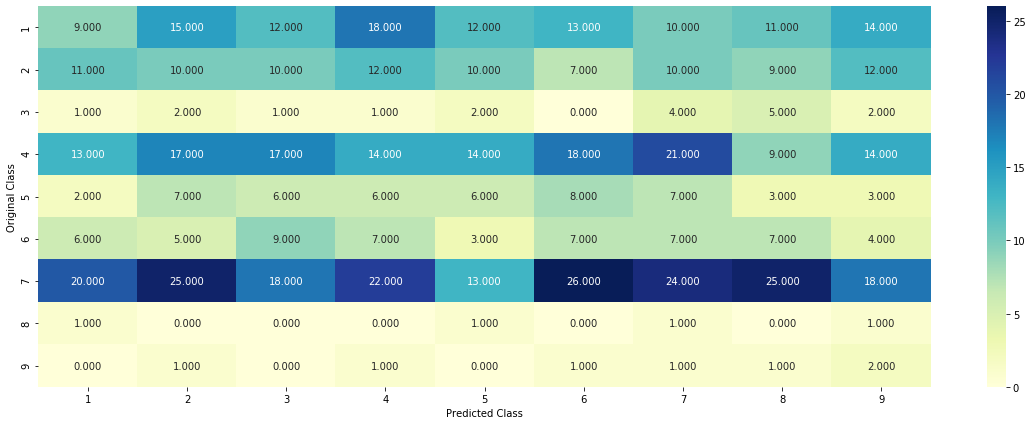

-------------------- Precision matrix --------------------


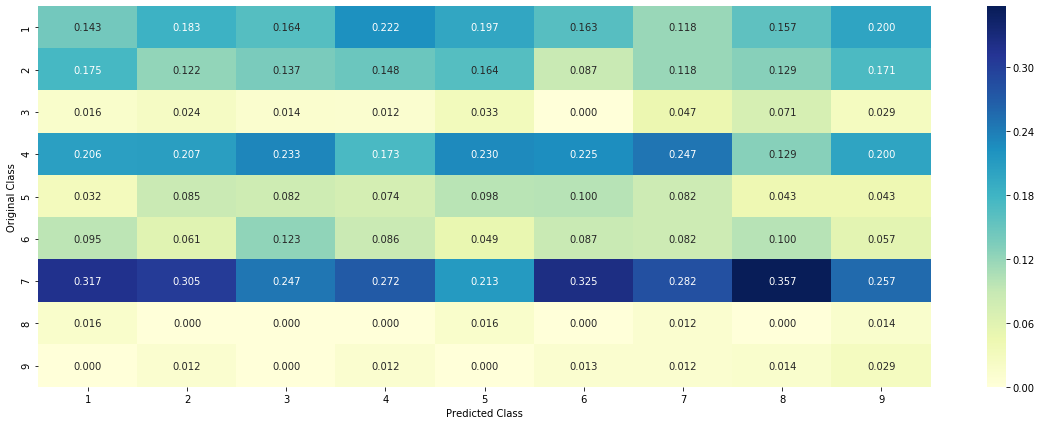

-------------------- Recall matrix --------------------


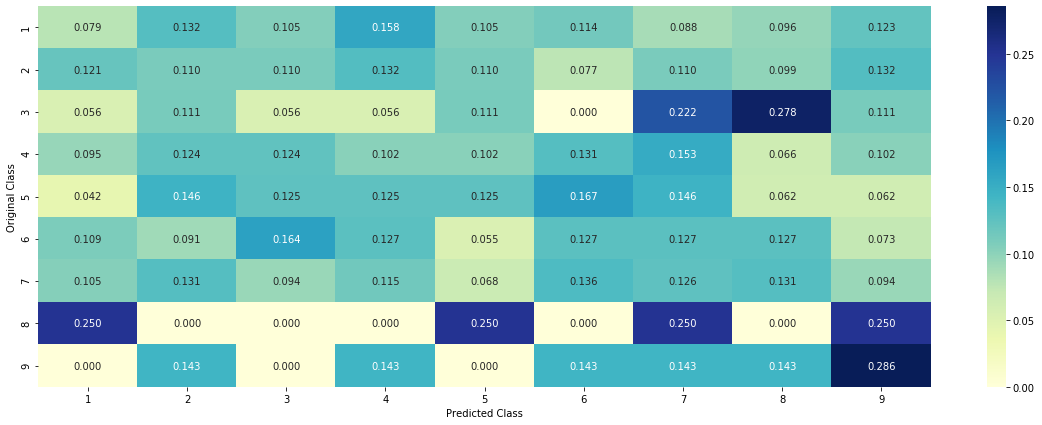

In [77]:
from sklearn.metrics.classification import log_loss

# we need to generate 9 numbers and the sum of numbers should be 1
# Each number is a probabilistic value for each class
# one solution is to genarate 9 numbers and divide each of the numbers by their sum

test_data_len = test_df.shape[0]  # No. of rows in test dataframe
cv_data_len = cv_df.shape[0]  # No. of rows in cv dataframe

# Gives a matrix, for each row in cv_df with 9 columns, for each classes one column is there
cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)  # array([[0.1173017 , 0.75339712, 0.87419797, 0.67174377, 0.30238956, 0.22311217, 0.66087963, 0.83912424, 0.76590687]])
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])  # Consider the twice sum as single sum as rand_probs is list inside list
print("Log loss on CV data using random model", log_loss(y_cv, cv_predicted_y, eps=1e-15))

# Create a matrix same as CV with each row has 9 attributes for each class probabilities
# The matrix has the same no. of rows as the no. of rows in test data
test_predicted_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test data using random model", log_loss(y_test, test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)  # Returns index for each row with maximum probabilistic value
plot_confusion_matrix(y_test, predicted_y+1) # To the indexm if we add 1, we'll get the class label

## 3.2 Univariate Analysis

In [78]:
# We are Converting each feature 'Gene' or 'Variation' into a vector of numerical values,
# so that we can process them later easily.

# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    

    for i, denominator in value_count.items():
        # for a value of feature in df (here i)
        # denominator will contain the number of time that particular feature occured in whole training data
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### 3.2.1. Univariate Analysis on Gene Feature

#### Q1. Gene, What type of feature it is ?

Gene is a categorical variable 

#### Q2. How many categories are there and How they are distributed?

In [79]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 233
BRCA1     172
TP53      105
EGFR       89
BRCA2      77
PTEN       75
KIT        62
BRAF       56
ALK        42
PIK3CA     41
PDGFRA     40
Name: Gene, dtype: int64


In [80]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 233 different categories of genes in the train data, and they are distibuted as follows


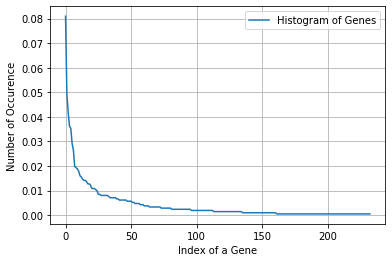

In [81]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label='Histogram of Genes')
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurence')
plt.legend()
plt.grid()
plt.show()

##### Takeaways-
This skewed distribution tells that very few genes occur very often and lots of genes occur few times

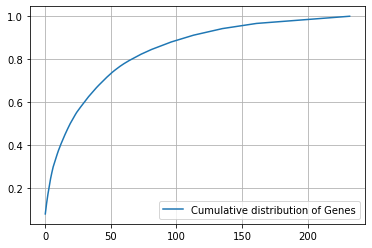

In [82]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

##### Takeaways-
Top 50 Genes contribute to 75% of the Genes

#### Q3. How to featurize this Gene feature ?

There are two ways we can featurize this variable-
1. One hot encoding (Better to use in Logistic and Linear Regression, Support Vector Machines)
2. Response Coding (Better in Naive Bayes, Random Forest)

##### Response Coding of Gene Feature

In [83]:
# Response Coding of Gene Feature
# Alpha is used for Laplace Smoothing as in Naive Bayes (Because the probabilistic values are sometimes very low)
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [84]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


##### One-Hot encoding of Gene feature

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [86]:
train_df['Gene'].head()

1282     HRAS
585     SMAD4
1612      VHL
830     ERCC3
428      TP53
Name: Gene, dtype: object

In [87]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'gata3',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 '

In [88]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 232)


#### Q4. How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  1e-05 The log loss is: 1.2041828442768365


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.0001 The log loss is: 1.1675648873845799
For values of alpha =  0.001 The log loss is: 1.1857899745836622


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.01 The log loss is: 1.2786094960586536
For values of alpha =  0.1 The log loss is: 1.4181888946771681


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  1 The log loss is: 1.4669878961154976


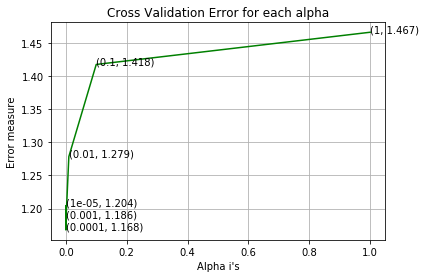

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of best alpha =  0.0001 The train log loss is: 1.0196266205268707
For values of best alpha =  0.0001 The cross validation log loss is: 1.1675648873845799
For values of best alpha =  0.0001 The test log loss is: 1.1680952800364666


In [89]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

# SGD Classifier is a General Purpose Classifier, using which we can do logistic regression (sigmoid, logloss)
# or Linear SVM (hinge loss)

alpha = [10 ** x for x in range(-5, 1)]  # Hyper-parameter for SGD Classifier (it is the lambda of my equation)

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')  # Using LR model, we may have not get probabilities, so we pass 
    # it through a sigmoid callibrator, which may be interpreted as Probabilities
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?
Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. 


In [90]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  233  genes in train dataset?
Ans
1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 517 out of  532 : 97.18045112781954


### 3.2.2. Univariate Analysis on Variation Feature
#### Q7. Variation, What type of feature is it ?
Variation is a categorical variable
#### Q8. How many categories are there?


In [91]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1928
Truncating_Mutations    59
Deletion                48
Amplification           46
Fusions                 26
Overexpression           3
E542K                    2
C618R                    2
G12C                     2
K117N                    2
V321M                    2
Name: Variation, dtype: int64


In [92]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1928 different categories of variations in the train data, and they are distibuted as follows


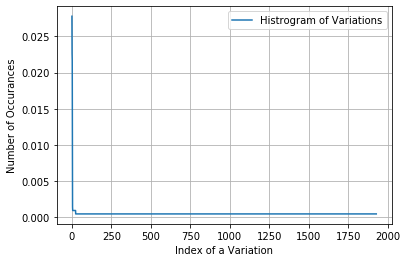

In [93]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

#### Takeaways-
* Decreasing order of frequency
* Only a few variations are the top most variations

[0.02777778 0.05037665 0.0720339  ... 0.99905838 0.99952919 1.        ]


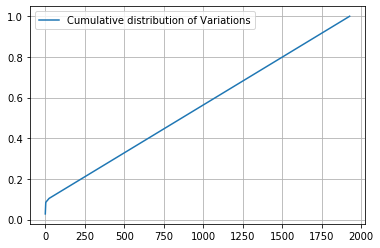

In [94]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

#### Takeaways
* Most variations occur only once or twice

#### Q9. How to featurize this Variation feature ?
1. One Hot Encoding
2. Response Coding

We will be using both these methods to featurize the Variation Feature 

In [95]:
# alpha is used for laplace smoothing
alpha = 1

start_time = time.time()

# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

print("Time taken for processing the entire text is ", time.time()-start_time, "seconds")

Time taken for processing the entire text is  170.64518308639526 seconds


In [96]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [97]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [98]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1958)


#### Q10. How good is this Variation feature in predicting y_i?
Let's build a model just like the earlier!

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  1e-05 The log loss is: 1.709876925018158
For values of alpha =  0.0001 The log loss is: 1.7082884735499775


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.001 The log loss is: 1.7156940253301964
For values of alpha =  0.01 The log loss is: 1.722146121175615


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.1 The log loss is: 1.736372739994699


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  1 The log loss is: 1.7415898700564294


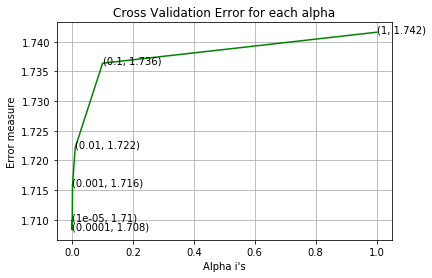

For values of best alpha =  0.0001 The train log loss is: 0.7400849668642503
For values of best alpha =  0.0001 The cross validation log loss is: 1.7082884735499775
For values of best alpha =  0.0001 The test log loss is: 1.7272597102414762


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [99]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?
Not sure! But lets be very sure using the below analysis.

In [100]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1928  genes in test and cross validation data sets?
Ans
1. In test data 72 out of 665 : 10.827067669172932
2. In cross validation data 49 out of  532 : 9.210526315789473


### 3.2.3 Univariate Analysis on Text Feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

To Featurize the Text Feature, we'll first do, One Hot Encoding of the Text Feature and it would be same as doing Bag Of Words (BoW)

In [121]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53830


Let's do the Response Coding

In [122]:
from collections import defaultdict

# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [123]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [124]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


In [125]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [126]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [127]:
from sklearn.preprocessing import normalize

# don't forget to normalize every feature (It's a GOOD Programming Habit)
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [128]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [129]:
from collections import Counter

# Number of words for a given frequency.
print(Counter(sorted_text_occur))  # 3:5423 means 5423 words occur only 3 times

Counter({3: 5472, 4: 3652, 5: 2965, 6: 2556, 10: 2208, 7: 1984, 8: 1720, 9: 1629, 12: 1339, 11: 1271, 14: 1020, 16: 911, 20: 861, 13: 856, 15: 813, 18: 631, 17: 563, 24: 538, 19: 472, 22: 455, 21: 427, 30: 425, 23: 418, 28: 407, 25: 367, 27: 362, 26: 342, 45: 330, 36: 305, 46: 288, 29: 276, 40: 269, 32: 257, 31: 255, 37: 249, 33: 245, 39: 223, 35: 219, 34: 216, 38: 212, 48: 200, 42: 200, 41: 198, 50: 187, 60: 175, 43: 173, 44: 170, 47: 157, 56: 152, 49: 147, 55: 146, 57: 138, 61: 132, 51: 130, 54: 128, 52: 126, 66: 125, 64: 123, 53: 123, 73: 114, 72: 114, 63: 113, 68: 111, 74: 108, 59: 103, 69: 102, 65: 99, 62: 99, 70: 96, 58: 95, 67: 94, 92: 91, 80: 84, 78: 84, 90: 83, 75: 82, 79: 80, 85: 79, 81: 77, 95: 76, 71: 76, 77: 74, 76: 72, 93: 68, 89: 67, 83: 65, 87: 64, 84: 64, 91: 63, 107: 62, 100: 62, 82: 62, 96: 60, 88: 60, 114: 59, 86: 59, 106: 57, 94: 56, 120: 55, 109: 53, 102: 53, 105: 51, 98: 51, 97: 51, 125: 50, 111: 50, 101: 49, 117: 48, 128: 47, 110: 46, 104: 46, 108: 45, 130: 44, 

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  1e-05 The log loss is: 1.3109920109535524


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.0001 The log loss is: 1.1342816840636267


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.001 The log loss is: 1.1085273682906513


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.01 The log loss is: 1.205377853184763


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  0.1 The log loss is: 1.4464309980559882


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of alpha =  1 The log loss is: 1.6682874124678684


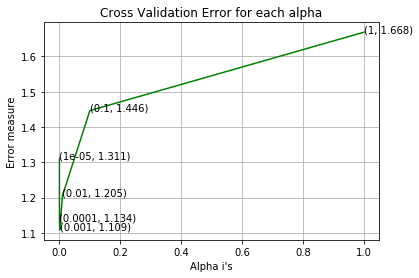

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of best alpha =  0.001 The train log loss is: 0.7120076623057124
For values of best alpha =  0.001 The cross validation log loss is: 1.1085273682906513
For values of best alpha =  0.001 The test log loss is: 1.1261275716477348


In [130]:
# Train a Logistic regression+Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?
Yes, it seems like! 

In [131]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [132]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.16 % of word of test data appeared in train data
98.176 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

In [133]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [134]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<center><h1>Stacking the three types of features</h1></center>

In [135]:
from scipy.sparse import hstack

# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [136]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56020)
(number of data points * number of features) in test data =  (665, 56020)
(number of data points * number of features) in cross validation data = (532, 56020)


In [137]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1. Base Line Model (Naive Bayes)

### 4.1.1. Hyper parameter tuning



for alpha = 1e-05


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2395215010668987
for alpha = 0.0001


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2388553529580644
for alpha = 0.001


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.249972820272069
for alpha = 0.1


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2579538475105658
for alpha = 1


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2412916560774587
for alpha = 10


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.351582636220974
for alpha = 100


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.3521579667059174
for alpha = 1000


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.3028964898142024


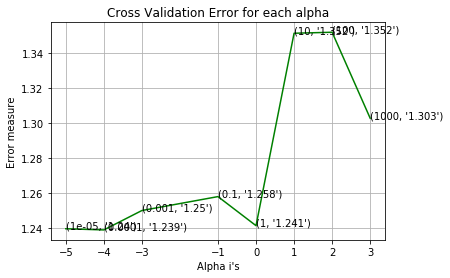

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of best alpha =  0.0001 The train log loss is: 0.8680128477374637
For values of best alpha =  0.0001 The cross validation log loss is: 1.2388553529580644
For values of best alpha =  0.0001 The test log loss is: 1.2397002931006758


In [138]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html

from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2388553529580644
Number of missclassified point : 0.37218045112781956


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


-------------------- Confusion matrix --------------------


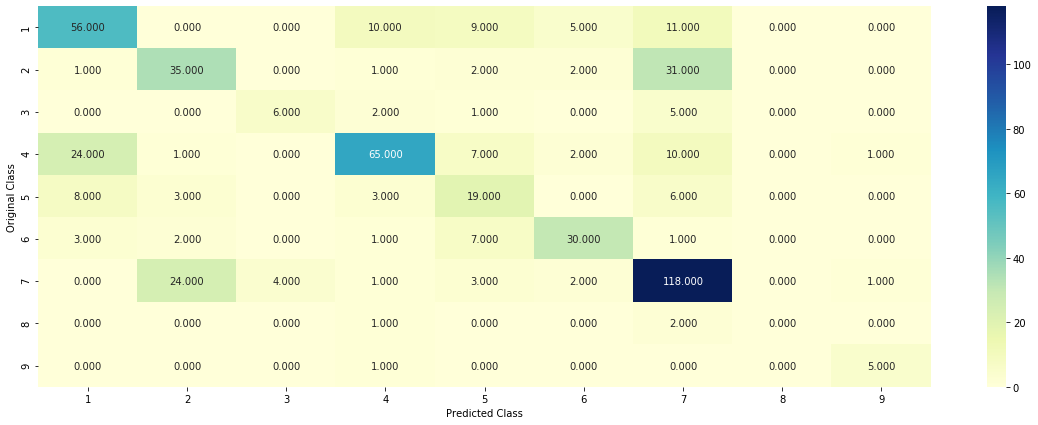

-------------------- Precision matrix --------------------


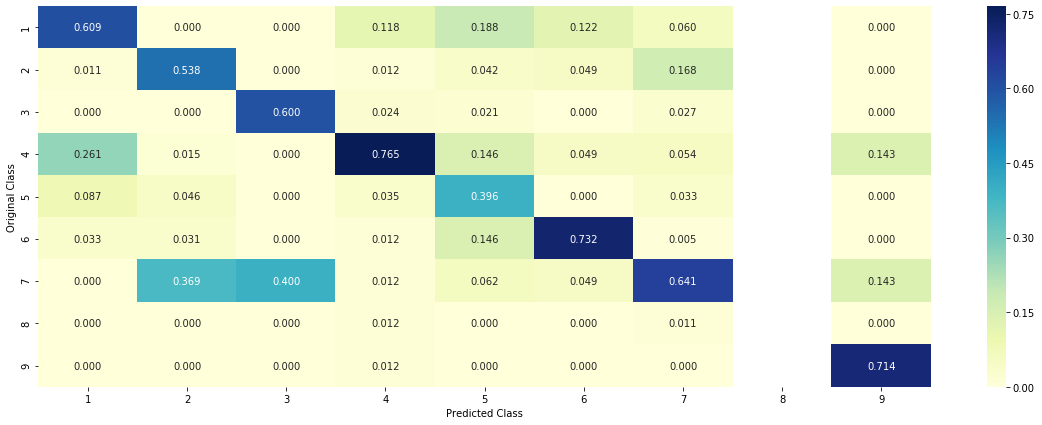

-------------------- Recall matrix --------------------


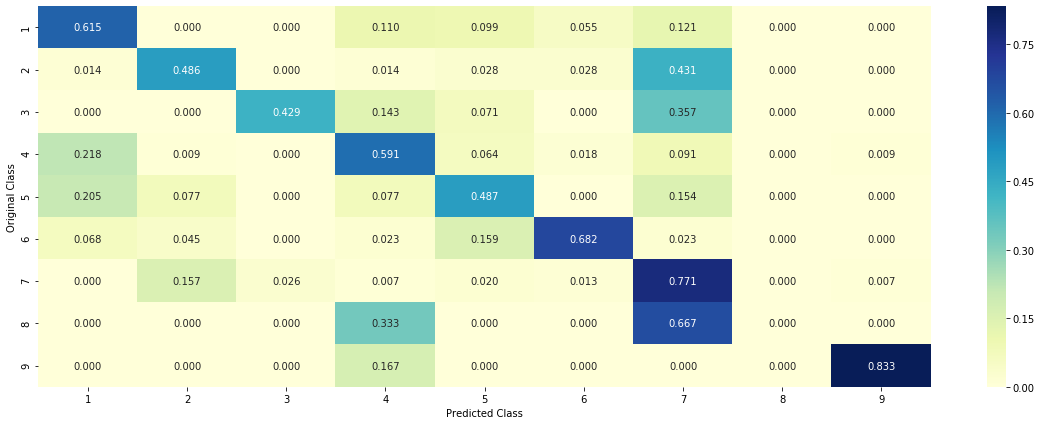

In [139]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### 4.1.3. Feature Importance, Correctly Classified Points

In [143]:
test_point_index = 101
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0979 0.0885 0.0127 0.1111 0.0399 0.0394 0.601  0.0052 0.0043]]
Actual Class : 7
--------------------------------------------------
18 Text feature [presence] present in test data point [True]
19 Text feature [activating] present in test data point [True]
20 Text feature [kinase] present in test data point [True]
21 Text feature [inhibitor] present in test data point [True]
22 Text feature [well] present in test data point [True]
23 Text feature [downstream] present in test data point [True]
24 Text feature [independent] present in test data point [True]
25 Text feature [contrast] present in test data point [True]
26 Text feature [expressing] present in test data point [True]
27 Text feature [recently] present in test data point [True]
28 Text feature [similar] present in test data point [True]
29 Text feature [shown] present in test data point [True]
30 Text feature [previously] present in test data point [True]
31 Text feature [ac

### 4.1.3. Feature Importance, Incorrectly Classified Points

In [141]:
test_point_index = 16
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4007 0.0987 0.0141 0.1231 0.1797 0.0435 0.1297 0.0058 0.0047]]
Actual Class : 1
--------------------------------------------------
14 Text feature [protein] present in test data point [True]
15 Text feature [function] present in test data point [True]
16 Text feature [one] present in test data point [True]
17 Text feature [two] present in test data point [True]
18 Text feature [type] present in test data point [True]
19 Text feature [affect] present in test data point [True]
20 Text feature [acids] present in test data point [True]
21 Text feature [amino] present in test data point [True]
22 Text feature [dna] present in test data point [True]
24 Text feature [sequence] present in test data point [True]
25 Text feature [wild] present in test data point [True]
26 Text feature [containing] present in test data point [True]
28 Text feature [binding] present in test data point [True]
29 Text feature [region] present in test data point 

## 4.2. K Nearest Neighbour Classification

for alpha = 5


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0709705537976313
for alpha = 11


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0398461172291191
for alpha = 15


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.065754941245212
for alpha = 21


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0880839923341263
for alpha = 31


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0845106344226885
for alpha = 41


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0974897564558637
for alpha = 51


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0874422225904448
for alpha = 99


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.0952975458594274


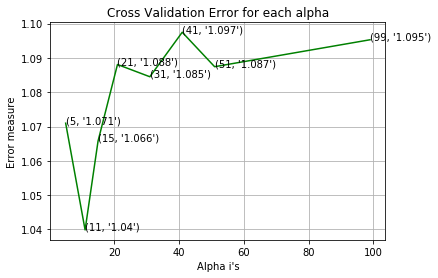

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of best alpha =  11 The train log loss is: 0.6413420717794688
For values of best alpha =  11 The cross validation log loss is: 1.0398461172291191
For values of best alpha =  11 The test log loss is: 1.0832016048471258


In [93]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.neighbors import KNeighborsClassifier

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### 4.2.2. Testing the model with best hyper paramters

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.0398461172291191
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


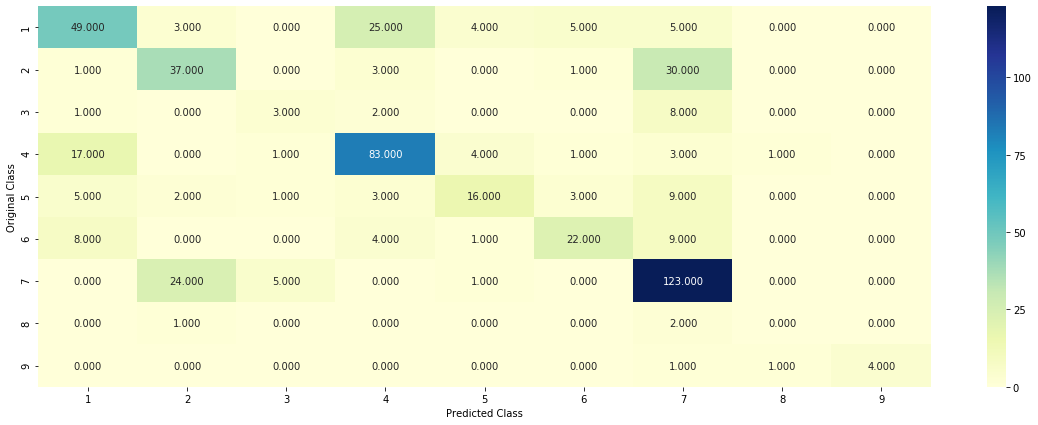

-------------------- Precision matrix --------------------


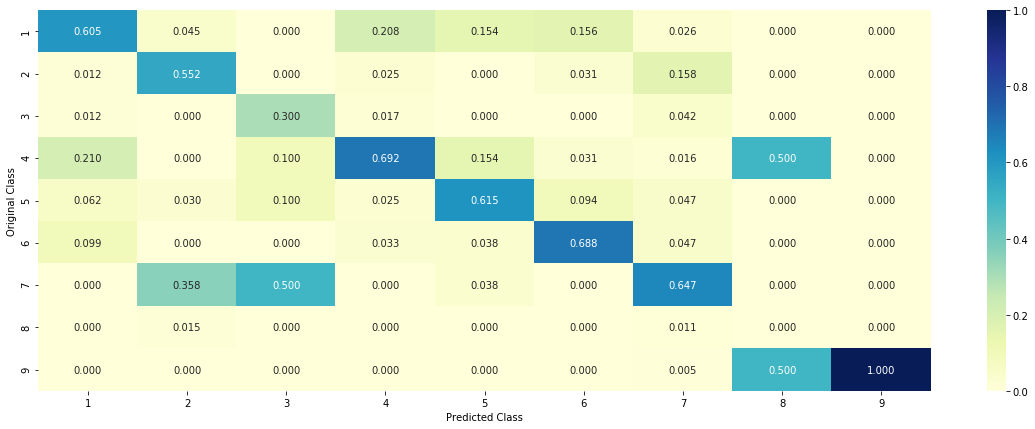

-------------------- Recall matrix --------------------


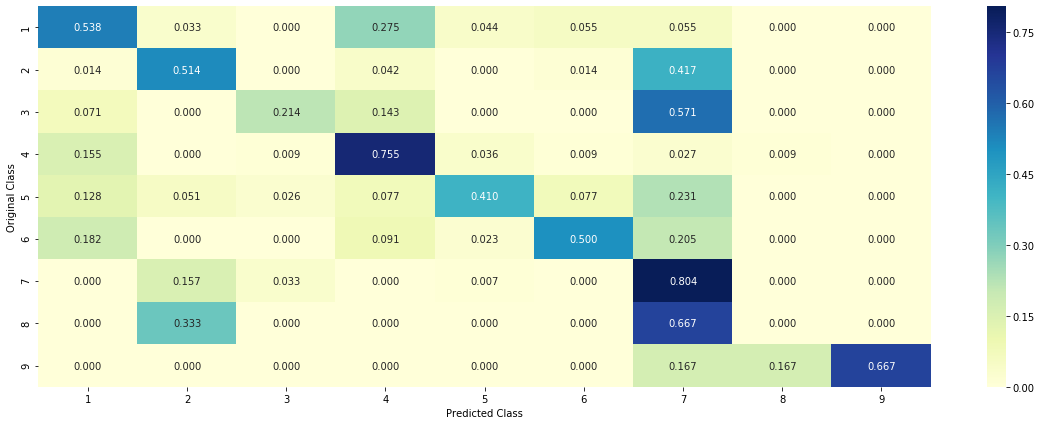

In [94]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### 4.2.3. Sample Query point -1

In [95]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 4 4 7 4]
Fequency of nearest points : Counter({4: 10, 7: 1})


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


### 4.2.4. Sample Query Point-2

In [100]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 53

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 2
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [2 6 6 6 6 6 6 6 8 2 7]
Fequency of nearest points : Counter({6: 7, 2: 2, 8: 1, 7: 1})


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


## 4.3. Logistic Regression (With Class Balancing)

### 4.3.1. Hyper Parameter Tuning

for alpha = 1e-06


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/calibration.py:453: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/lib/python3.7/site-packages/sklearn/calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/usr/lib/python3.7/site-packages/sklearn/calibration.py:453: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/lib/python3.7/site-packages/sklearn/calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/usr/lib/python3.7/site-packages/sklearn/calibration.py:453: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/lib/python3.7/site-packages/sklearn/calib

Log Loss : 1.3926855204262594
for alpha = 1e-05


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/calibration.py:453: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/lib/python3.7/site-packages/sklearn/calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/usr/lib/python3.7/site-packages/sklearn/calibration.py:453: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/lib/python3.7/site-packages/sklearn/calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/usr/lib/python3.7/site-packages/sklearn/calibration.py:453: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/usr/lib/python3.7/site-packages/sklearn/calib

Log Loss : 1.4269854444898913
for alpha = 0.0001


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2056764444466965
for alpha = 0.001


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.125310513697111
for alpha = 0.01


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.1510539450877182
for alpha = 0.1


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.4764390673180037
for alpha = 1


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.704971817426205
for alpha = 10


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.7307768039261002
for alpha = 100


/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.7336062883390622


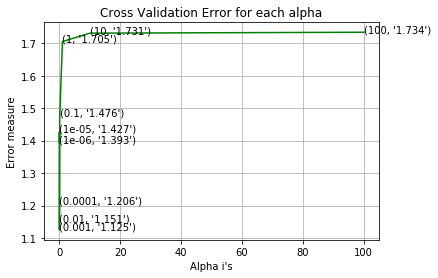

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


For values of best alpha =  0.001 The train log loss is: 0.5579141514337748
For values of best alpha =  0.001 The cross validation log loss is: 1.125310513697111
For values of best alpha =  0.001 The test log loss is: 1.1740876538580074


In [101]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.2. Testing the model with best hyper paramters

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss : 1.125310513697111
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


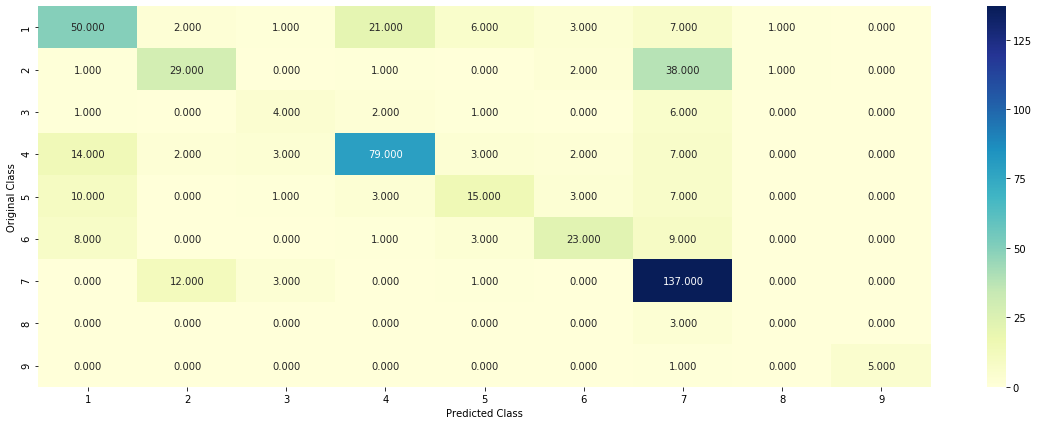

-------------------- Precision matrix --------------------


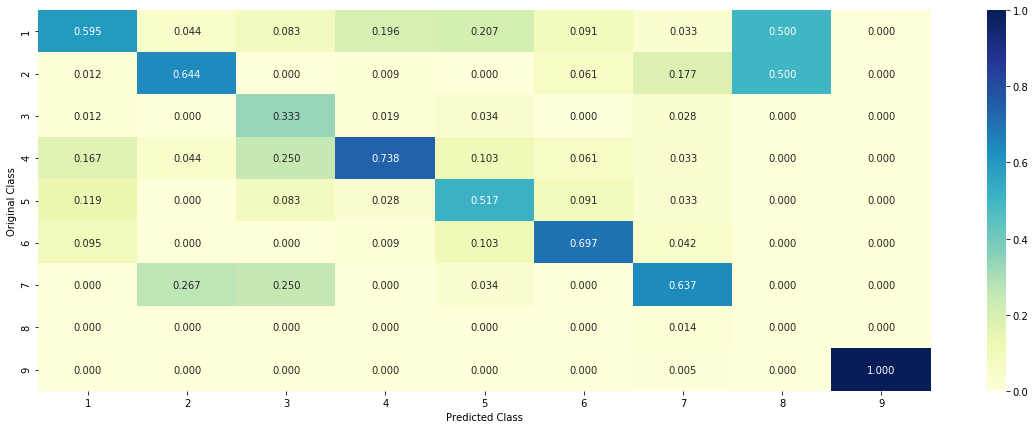

-------------------- Recall matrix --------------------


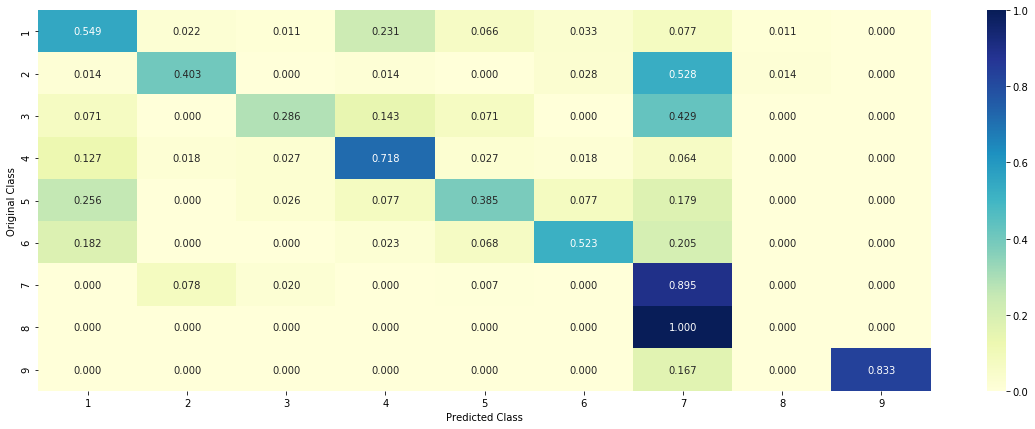

In [104]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### 4.3.3. Feature Importance

In [105]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

#### 4.3.3.1 Correctly Classified point

In [107]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0559 0.0503 0.0147 0.6992 0.0282 0.0143 0.1256 0.0048 0.007 ]]
Actual Class : 4
--------------------------------------------------
139 Text feature [proteasome] present in test data point [True]
152 Text feature [suppressor] present in test data point [True]
259 Text feature [stability] present in test data point [True]
289 Text feature [missense] present in test data point [True]
341 Text feature [slips] present in test data point [True]
381 Text feature [microscopy] present in test data point [True]
498 Text feature [bannayan] present in test data point [True]
Out of the top  500  features  7 are present in query point


#### 4.3.3.2. Incorrectly Classified point

In [109]:
test_point_index = 18
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0416 0.0853 0.0088 0.05   0.0337 0.0176 0.7479 0.0074 0.0077]]
Actual Class : 6
--------------------------------------------------
80 Text feature [ligand] present in test data point [True]
92 Text feature [receptors] present in test data point [True]
126 Text feature [extracellular] present in test data point [True]
161 Text feature [y1068] present in test data point [True]
229 Text feature [activation] present in test data point [True]
233 Text feature [egf] present in test data point [True]
245 Text feature [breaking] present in test data point [True]
253 Text feature [therapeutics] present in test data point [True]
280 Text feature [distinctly] present in test data point [True]
282 Text feature [receptor] present in test data point [True]
296 Text feature [tyrosines] present in test data point [True]
298 Text feature [transformation] present in test data point [True]
302 Text feature [activating] present in test data point [Tru